In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame

from typing import List, Tuple, Dict, Union
from datetime import datetime
from tqdm import tqdm

In [2]:
OLD_COLUMNS = ["TIME","BIKE STANDS","AVAILABLE BIKE STANDS","AVAILABLE BIKES"]
NEW_COLUMNS = ["TIME","BIKE_STANDS","AVAILABLE_BIKE_STANDS","AVAILABLE_BIKES"]
COLUMN_RENAME_MAP = {"BIKE STANDS": "BIKE_STANDS", 'AVAILABLE BIKE STANDS': 'AVAILABLE_BIKE_STANDS', 'AVAILABLE BIKES': 'AVAILABLE_BIKES'}
PERIODS = ["pre-pandemic", "pandemic", "post-pandemic"]

In [3]:
def load_and_rename_columns(file_path: str, selected_columns: List[str]) -> pd.DataFrame:
    data_frame = pd.read_csv(file_path, usecols=selected_columns)
    if "Q" in file_path:
        data_frame.rename(columns=COLUMN_RENAME_MAP, inplace=True)
    return data_frame

In [4]:
def split_dataframe_by_time(filename: str, time_regex: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data_frame = load_and_rename_columns(filename, OLD_COLUMNS if "Q" in filename else NEW_COLUMNS)
    split_index = data_frame[data_frame["TIME"].str.contains(time_regex)].index[0]
    return data_frame[:split_index], data_frame[split_index:]

In [5]:
def load_data_by_periods(folder: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    data_frames = {}
    pre_pandemic_data, pandemic_start_data = split_dataframe_by_time(f"{folder}/start-pandemic/2020Q1.csv","2020-03-17 .*")
    pandemic_end_data, post_pandemic_data = split_dataframe_by_time(f"{folder}/end-pandemic/2022January.csv", "2022-01-28 .*")

    for period in PERIODS:
        period_data_frames = []
        for subdir, _, files in os.walk(f"{folder}/{period}"):
            for file in tqdm(files, desc=f"Reading {subdir}"):
                data_frame = load_and_rename_columns(os.path.join(subdir, file), OLD_COLUMNS if "Q" in file else NEW_COLUMNS)
                period_data_frames.append(data_frame)
                del data_frame
        
            if period == "pre-pandemic":
                period_data_frames.append(pre_pandemic_data)
                del pre_pandemic_data
            elif period == "pandemic":
                period_data_frames.insert(0, pandemic_start_data)
                period_data_frames.append(pandemic_end_data)
                del pandemic_start_data
                del pandemic_end_data
            elif period == "post-pandemic":
                period_data_frames.insert(0, post_pandemic_data)
                del post_pandemic_data
            
        data_frames[period] = pd.concat(period_data_frames)
        
    return data_frames["pre-pandemic"], data_frames["pandemic"], data_frames["post-pandemic"]

In [6]:
def round_time_to_nearest_five_minutes(time_string: str) -> datetime:
    # Define the datetime format
    datetime_format = "%Y-%m-%d %H:%M:%S"
    
    # Parse the input string into a datetime object
    datetime_object = datetime.strptime(time_string, datetime_format)

    # Round down to the nearest 5 minutes
    rounded_datetime = datetime(datetime_object.year, datetime_object.month, datetime_object.day, 
                                datetime_object.hour, (datetime_object.minute // 5) * 5)

    return rounded_datetime

In [7]:
# Combine time/dates of different stations into one value per time
def aggregate_data_by_time(data_frame: DataFrame, period: str) -> DataFrame:
    unique_data_frame = data_frame.drop_duplicates()
    
    # Round times to nearest 5 minutes
    tqdm.pandas(desc=f"Rounding {period} times to closest 5 minutes.")
    unique_data_frame['TIME'] = unique_data_frame['TIME'].progress_apply(round_time_to_nearest_five_minutes)

    # Aggregate times together, with all counts summed
    return unique_data_frame.groupby(unique_data_frame['TIME'], as_index=False).aggregate({'BIKE_STANDS': 'sum', 'AVAILABLE_BIKE_STANDS': 'sum', 'AVAILABLE_BIKES': 'sum'})

# Write data for dataframe to a csv
def write_aggregated_data_to_csv(data_frame: DataFrame, period_name: str):
    aggregated_data_frame = aggregate_data_by_time(data_frame, period_name)
    aggregated_data_frame.to_csv(f"data/rounded_{period_name}.csv")

# Write data for all periods to csvs
def write_all_period_data_to_csv(pre_pandemic_data: DataFrame, pandemic_data: DataFrame, post_pandemic_data: DataFrame):
    write_aggregated_data_to_csv(pre_pandemic_data, "pre-pandemic")
    write_aggregated_data_to_csv(pandemic_data, "pandemic")
    write_aggregated_data_to_csv(post_pandemic_data, "post-pandemic")

In [8]:
# Read cleaned data for all periods into dataframes
def read_cleaned_data() -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    pre_pandemic = pd.read_csv("data/rounded_pre-pandemic.csv",parse_dates=['TIME'])
    pandemic = pd.read_csv("data/rounded_pandemic.csv",parse_dates=['TIME'])
    post_pandemic = pd.read_csv("data/rounded_post-pandemic.csv",parse_dates=['TIME'])
    return pre_pandemic, pandemic, post_pandemic

# Given a datetime in a string, convert it to datetime containing just the date
def round_to_day(time: str) -> datetime:
    dt_format = "%Y-%m-%d %H:%M:%S"
    dt = datetime.strptime(time, dt_format)
    return datetime(dt.year, dt.month, dt.day, 0, 0, 0)

# Average all bike usage values in a dataframe over each day
def avg_over_day(df: pd.DataFrame, period: str) -> pd.DataFrame:
    tqdm.pandas(desc=f"Rounding {period} times to day.")
    df['TIME'] = df['TIME'].progress_apply(round_to_day)
    return df.groupby(df['TIME'], as_index=False).aggregate({'BIKE_STANDS': 'mean', 'AVAILABLE_BIKE_STANDS': 'mean', 'AVAILABLE_BIKES': 'mean'})

# Write the daily average data for a dataframe to a csv
def write_daily_data(df: pd.DataFrame, name: str):
    df = avg_over_day(df, name)
    df.to_csv(f"data/daily_{name}.csv")

In [9]:
# Write daily averages for all periods to csvs
def write_daily_data_for_all_periods(pre_pandemic_data: DataFrame, pandemic_data: DataFrame, post_pandemic_data: DataFrame):
    write_daily_data(pre_pandemic_data, "pre-pandemic")
    write_daily_data(pandemic_data, "pandemic")
    write_daily_data(post_pandemic_data, "post-pandemic")

# Read daily averages for all periods to dataframes
def load_daily_data_for_all_periods() -> Tuple[DataFrame, DataFrame, DataFrame]:
    pre_pandemic_daily_data = pd.read_csv("data/pre-pandemic.csv", parse_dates=['TIME'])
    pandemic_daily_data = pd.read_csv("data/pandemic.csv", parse_dates=['TIME'])
    post_pandemic_daily_data = pd.read_csv("data/post-pandemic.csv", parse_dates=['TIME'])
    
    return pre_pandemic_daily_data, pandemic_daily_data, post_pandemic_daily_data

In [10]:
def plot_all_stand_availability(pre_pandemic_df: pd.DataFrame, pandemic_df: pd.DataFrame, post_pandemic_df: pd.DataFrame):
    # Set the background to gray scale
    sns.set(style="darkgrid")
    
    # Set the color palette to pastel
    sns.set_palette("pastel")

    # Plot the data
    sns.lineplot(x='TIME', y='AVAILABLE_BIKE_STANDS', data=pre_pandemic_df, label="Pre-pandemic")
    sns.lineplot(x='TIME', y='AVAILABLE_BIKE_STANDS', data=pandemic_df, label="Pandemic")
    sns.lineplot(x='TIME', y='AVAILABLE_BIKE_STANDS', data=post_pandemic_df, label="Post-pandemic")

    # Set the labels and title
    plt.xlabel("Time/Date", fontsize=12)
    plt.ylabel("Number of Available Bike Stands", fontsize=12)
    plt.title("Number of Available Bike Stands (Bike Usage) - Pre, During, and Post Pandemic", fontsize=14)

    # Rotate x-axis labels
    plt.xticks(rotation="vertical")

    # Move the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

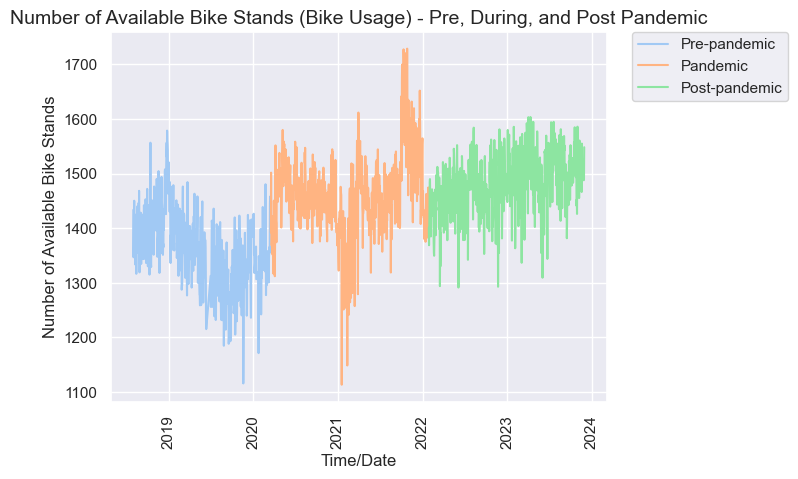

In [11]:
def main():
    pre_pandemic, pandemic, post_pandemic = load_daily_data_for_all_periods()
    plot_all_stand_availability(pre_pandemic, pandemic, post_pandemic)

if __name__ == "__main__":
    main()